# Chargement et preprocessing des données

## Librairies

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy
import warnings
import random as rndm
from os.path import exists
import pickle
import json
from sklearn.model_selection import train_test_split
from IPython.core.display import HTML
from nltk.corpus import stopwords
import preprocessor as p # tweet-preprocessor https://github.com/s/preprocessor

## Settings

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('dark_background')
tln = spacy.load("en_core_web_sm")
seed = 1
rndm.seed(seed)
np.random.seed(seed)

## Constantes

In [3]:
sav_path = "./sav/"

## Importation du dataset

In [4]:
data = pd.read_csv("./data/training.1600000.processed.noemoticon.csv", header=None, encoding='ISO-8859-1')

In [5]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Nous allons renommer les colonnes pour nous simplifier la tâche

In [6]:
cols = [
    "target",
    "ids",
    "date",
    "flag",
    "user",
    "text"
]
data.columns = cols
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [25]:
print("Notre dataset contient {} lignes et {} colonnes\n\n".format(data.shape[0], data.shape[1]))
data.info()

Notre dataset contient 1600000 lignes et 6 colonnes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


Ce que contiennent les colonnes :
- **target** : la polarité du tweet (0 = négatif, 2 = neutre, 4 = positif)
- **ids** : l'identifiant du tweet
- **date** : la date du tweet (ex : Sat May 16 23:58:44 UTC 2009)
- **flag** : la requête (lyx). S'il n'y en a pas, la valeur est NO_QUERY
- **user** : l'utilisateur ayant tweeté
- **text** : le texte du tweet

## Identification de la cible

"La cible correspond à la colonne ```target```" (*Captain Obvious, Circa 2022*)

In [26]:
data["target"].unique()

array([0, 4], dtype=int64)

Nous n'avons pas de tweet avec une polarité neutre. Nous nous retrouvons donc avec 2 valeurs possibles : 0 et 4.
- 0 pour un sentiment négatif
- 4 pour un sentiment positif

Remplaçons la valeur 4 par 1, plus logique pour un label qui s'avère être binaire

In [27]:
data["target"] = data["target"].replace(4, 1)

Maintenant, regardons quelle est la répartition de ces deux labels :

<AxesSubplot:title={'center':'Répartition des tweets par polarité'}, ylabel='target'>

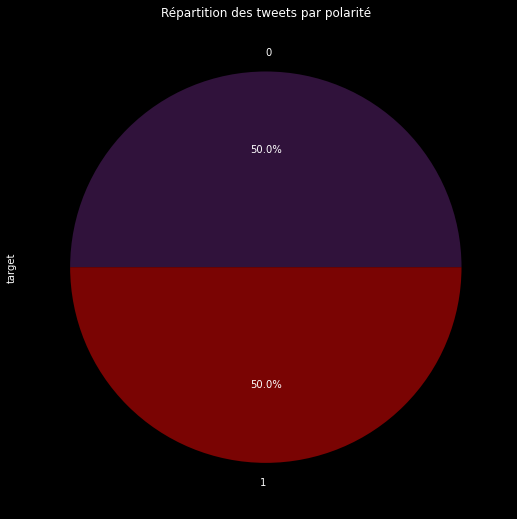

In [28]:
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0,1,len(data["target"].value_counts().tolist())))

plt.figure()
plt.set_cmap("Greens")
data["target"].value_counts().plot.pie(
    title="Répartition des tweets par polarité",
    autopct="%1.1f%%",
    figsize=(9,9),
    colors=colors
)

Nous pouvons voir que les deux classes sont équitablement réparties.

## Séparation du jeu de données

Nous allons séparer le dataset en différents datasets :

Comparison (cmp) : servira à comparer nos trois approches (API sur étagère, modèle simple, modèle avancé)
Validation (val) : servira à sélectionner le meilleur modèle avancé et à le fine-tuner
Train (train) : servira pour entraîner notre meilleur modèle
Train_sample (train_smpl) : un échantillon de Train pour aller plus vite dans un premier temps
Test (test) : servira pour évaluer le meilleur modèle avancé

In [29]:
CMP_SIZE = 1600 # 800 pour limiter les coûts sur Azure
VAL_SIZE = 50000
SMPL_SIZE = 8000
df_cmp, data = train_test_split(
    data,
    stratify=data["target"],
    train_size=CMP_SIZE,
    random_state=seed
)
df_val, data = train_test_split(
    data,
    stratify=data["target"],
    train_size=VAL_SIZE,
    random_state=seed
)
df_train, df_test = train_test_split(
    data,
    stratify=data["target"],
    train_size=0.8,
    random_state=seed
)
df_train_smpl, _ = train_test_split(
     df_train, 
     stratify=df_train["target"], 
     train_size=SMPL_SIZE, 
     random_state=seed
 )

1548400 lignes


0    774200
1    774200
Name: target, dtype: int64

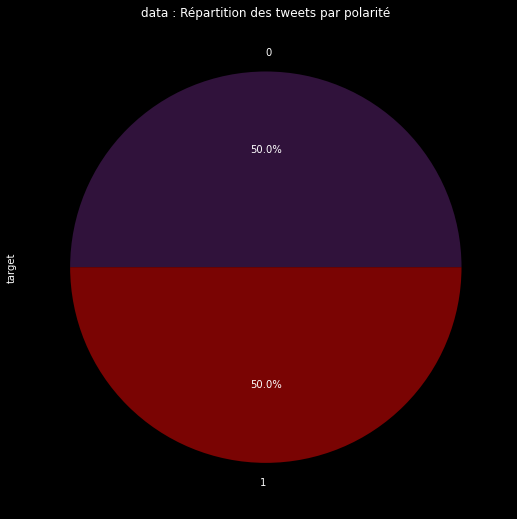

1600 lignes


1    800
0    800
Name: target, dtype: int64

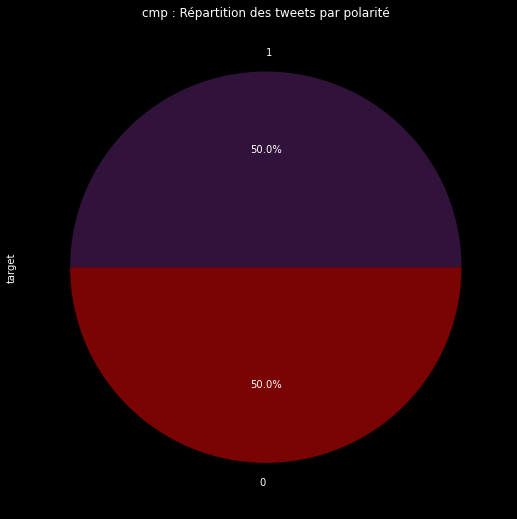

50000 lignes


0    25000
1    25000
Name: target, dtype: int64

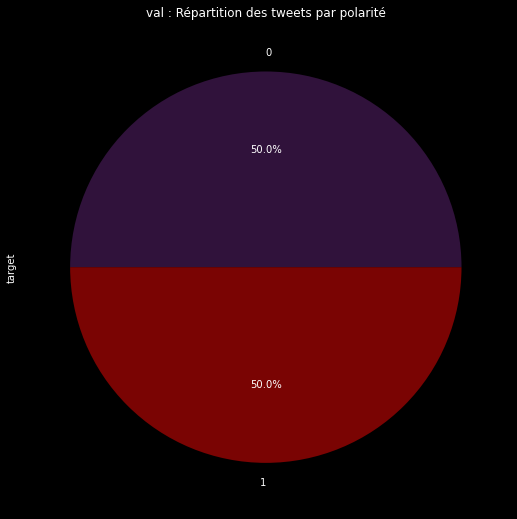

1238720 lignes


0    619360
1    619360
Name: target, dtype: int64

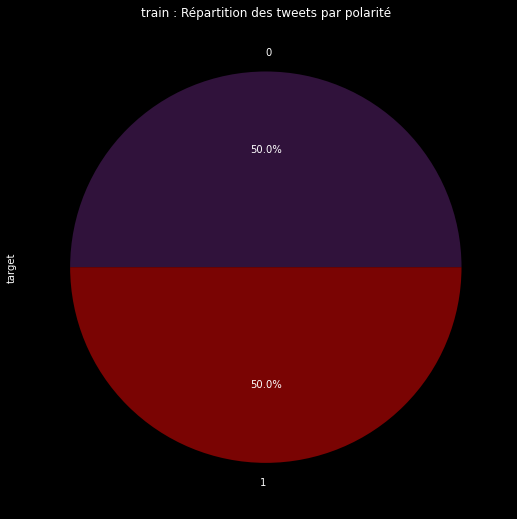

8000 lignes


0    4000
1    4000
Name: target, dtype: int64

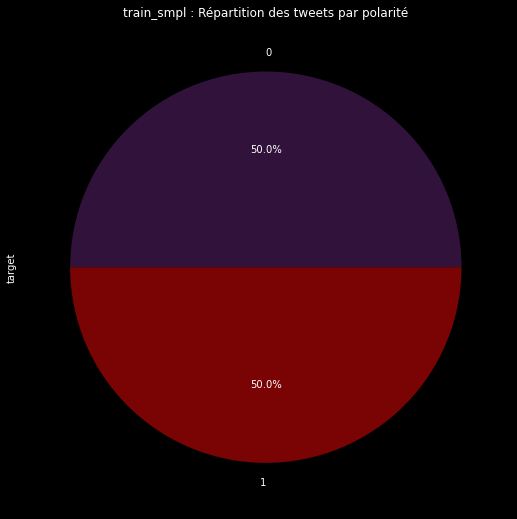

309680 lignes


1    154840
0    154840
Name: target, dtype: int64

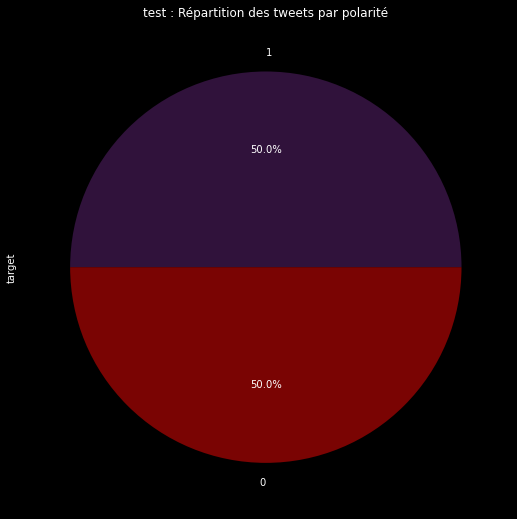

In [30]:
ls_df = {
    "data" : data,
    "cmp" : df_cmp,
    "val" : df_val,
    "train" : df_train,
    "train_smpl" : df_train_smpl,
    "test" : df_test
}

for dataset in ls_df:
    display(HTML("<h1>{}</h1>".format(dataset)))
    print("{} lignes".format(ls_df[dataset].shape[0]))
    display(ls_df[dataset]["target"].value_counts())
    ls_df[dataset]["target"].value_counts().plot.pie(
        title="{} : Répartition des tweets par polarité".format(dataset),
        autopct="%1.1f%%",
        figsize=(9,9),
        colors=colors
    )
    plt.show()

## Preprocessing

### Suppression des stopwords

In [31]:
# stop = stopwords.words('english')
# for dataset in ls_df:
#     print("Supresion des stopwords dans les tweets de {}...".format(dataset))
#     ls_df[dataset]["text"] = ls_df[dataset]["text"].apply(
#         lambda x: ' '.join([word for word in x.split() if word not in (stop)])
#     )

Bien que la radicalisation et la lemmatisation aident à l'analyse des sentiments, le filtrage des mots vides n'est pas aussi simple. Le but des mots vides est de supprimer les mots inutiles, mais si vous regardez les listes de mots vides disponibles, celle de la bibliothèque NLTK par exemple, vous trouvez des mots qui peuvent potentiellement véhiculer des sentiments négatifs tels que : not, don't, hasn' t…. mais pour le problème d'analyse des sentiments, nous voulons garder les mots négatifs. Il est évident que « C'est un bon jeu » et « Ce n'est pas un bon jeu » fournissent un sentiment opposé. Par conséquent, il faut soit modifier la liste des mots vides pour exclure les mots qui véhiculent une signification négative, soit ne pas utiliser de mots vides du tout. Nous avons choisi cette dernière option

### tweet-preprocessor

Preprocessor est une bibliothèque spécialisée dans le prétraitement des tweets. Nous testerons le nettoyage complet des tweets (par défaut) qui enlève tous les éléments superflus, mais aussi un nettoyage plus léger où l'on paramètrera la librairie pour n'enlever que les URL et les EMOJI

Pour plus d'informations sur la librairie tweet-preprocessing, voir [ici](https://github.com/s/preprocessor)

#### Nettoyage complet (par défaut)

In [32]:
# if (not exists(sav_path+"X.sav")) or (not exists(sav_path+"y.sav")):
if True:
    # Nettoyage complet (par défaut)
    X = {}
    y = {}
    for dataset in ls_df:
        print("Nettoyage complet des tweets de {}...".format(dataset))
        ls_df[dataset]["preprocessed_full"] = ls_df[dataset]["text"].apply(lambda txt : p.clean(txt))
        display(ls_df[dataset]["preprocessed_full"].head())

        print("Préparation de X[{}] et y[{}]...".format(dataset, dataset))
        X[dataset] = ls_df[dataset]["preprocessed_full"].values
        y[dataset] = ls_df[dataset]["target"].values
        print("X[{}] Shape : {}".format(dataset, X[dataset].shape))
        print("y[{}] Shape : {}".format(dataset, y[dataset].shape))
        print("\n"*3)
else :
    print("Chargement de X depuis {}...".format(sav_path+"X.sav"))
    X = pickle.load(open(sav_path+"X.sav", "rb"))
    print("Chargement de y depuis {}...".format(sav_path+"y.sav"))
    y = pickle.load(open(sav_path+"y.sav", "rb"))
    for dataset in ls_df:
        print("\n")
        print("X[{}] Shape : {}".format(dataset, X[dataset].shape))
        print("y[{}] Shape : {}".format(dataset, y[dataset].shape))

Nettoyage complet des tweets de data...


274139                    praying for that air france flight
406590                                        what's up mr!?
416876     Circus = MINDBLOWING! haha. clowns were super ...
26445      The worst part was no management to take my co...
1056248    If it makes you feel any better, daughter had ...
Name: preprocessed_full, dtype: object

Préparation de X[data] et y[data]...
X[data] Shape : (1548400,)
y[data] Shape : (1548400,)




Nettoyage complet des tweets de cmp...


1403617    Jelly sweets. So of course I had to buy Haribo...
891773     okay that's good! oh and you missed an AMAZING...
170240                               it's only on in glasgow
1352691    I was gonna buy both, so thanks!! is that my &...
1537882    it's a link to the pic you asked viewers to se...
Name: preprocessed_full, dtype: object

Préparation de X[cmp] et y[cmp]...
X[cmp] Shape : (1600,)
y[cmp] Shape : (1600,)




Nettoyage complet des tweets de val...


195181                     he dont have any twitter account.
1464164    Those are some pretty strong words for a man w...
1406181                        Love makes the world go round
1178361    Listening to Aaron Barnhart's Debut album, Mis...
793341                            is not having a good night
Name: preprocessed_full, dtype: object

Préparation de X[val] et y[val]...
X[val] Shape : (50000,)
y[val] Shape : (50000,)




Nettoyage complet des tweets de train...


169335                   Is at work ohwell need money so : D
24035      Eww, it's raining outside It was SO pretty yes...
916565              Getting anxious for Blink- 's new album!
1166237    Back from the quick journey to the shops - now...
330659     i wish i could go you guys have to come to Pue...
Name: preprocessed_full, dtype: object

Préparation de X[train] et y[train]...
X[train] Shape : (1238720,)
y[train] Shape : (1238720,)




Nettoyage complet des tweets de train_smpl...


155649    A Page A Day In The Month Of May is almost ove...
761765                                      is really ill x
445367       Man today is a rough day....and its only am...
636176    asks, &quot;What part of last call don't peopl...
930007    yay! LOL. i actually wanna start wearing some ...
Name: preprocessed_full, dtype: object

Préparation de X[train_smpl] et y[train_smpl]...
X[train_smpl] Shape : (8000,)
y[train_smpl] Shape : (8000,)




Nettoyage complet des tweets de test...


1113194           is feeling duper sleeping about now! haha.
1470236    I have tried both but Yorkshire GOld is my fav...
305157     I always seem to enjoy a Monday bunk better th...
1187112    are you going to be at the Jonas Brothers conc...
291710     oh wow - I have black, fine hair and it's stic...
Name: preprocessed_full, dtype: object

Préparation de X[test] et y[test]...
X[test] Shape : (309680,)
y[test] Shape : (309680,)






#### Nettoyage léger

In [33]:
# if (not exists(sav_path+"X_light.sav")) or (not exists(sav_path+"y_light.sav")):
if True:
    # Nettoyage léger
    p.set_options(p.OPT.URL, p.OPT.EMOJI)
    X_light = {}
    y_light = {}
    for dataset in ls_df:
        print("Nettoyage light des tweets de {}...".format(dataset))
        ls_df[dataset]["preprocessed_light"] = ls_df[dataset]["text"].apply(lambda txt : p.clean(txt))
        display(ls_df[dataset]["preprocessed_light"].head())

        print("Préparation de X_light[{}] et y_light[{}]...".format(dataset, dataset))
        X_light[dataset] = ls_df[dataset]["preprocessed_light"].values
        y_light[dataset] = ls_df[dataset]["target"].values
        print("X_light[{}] Shape : {}".format(dataset, X_light[dataset].shape))
        print("y_light[{}] Shape : {}".format(dataset, y_light[dataset].shape))
        print("\n"*3)
else :
    print("Chargement de X_light depuis {}...".format(sav_path+"X_light.sav"))
    X_light = pickle.load(open(sav_path+"X_light.sav", "rb"))
    print("Chargement de y_light depuis {}...".format(sav_path+"y_light.sav"))
    y_light = pickle.load(open(sav_path+"y_light.sav", "rb"))
    for dataset in ls_df:
        print("\n")
        print("X_light[{}] Shape : {}".format(dataset, X_light[dataset].shape))
        print("y_light[{}] Shape : {}".format(dataset, y_light[dataset].shape))

Nettoyage light des tweets de data...


274139                    praying for that air france flight
406590                            @JacobLovie what's up mr!?
416876     Circus = MINDBLOWING! haha. clowns were super ...
26445      The worst part was no management to take my co...
1056248    @MaternalSpark If it makes you feel any better...
Name: preprocessed_light, dtype: object

Préparation de X_light[data] et y_light[data]...
X_light[data] Shape : (1548400,)
y_light[data] Shape : (1548400,)




Nettoyage light des tweets de cmp...


1403617    @Dot12b Jelly sweets. So of course I had to bu...
891773     @kend_ohh okay that's good! oh and you missed ...
170240                 @laurenRIOT_x it's only on in glasgow
1352691    I was gonna buy both, so thanks!! is that my &...
1537882    @alexa_chung it's a link to the pic you asked ...
Name: preprocessed_light, dtype: object

Préparation de X_light[cmp] et y_light[cmp]...
X_light[cmp] Shape : (1600,)
y_light[cmp] Shape : (1600,)




Nettoyage light des tweets de val...


195181              @nmseq he dont have any twitter account.
1464164    @D_Hock Those are some pretty strong words for...
1406181                        Love makes the world go round
1178361    Listening to Aaron Barnhart's Debut album, Mis...
793341                            is not having a good night
Name: preprocessed_light, dtype: object

Préparation de X_light[val] et y_light[val]...
X_light[val] Shape : (50000,)
y_light[val] Shape : (50000,)




Nettoyage light des tweets de train...


169335                   Is at work ohwell need money so : D
24035      Eww, it's raining outside It was SO pretty yes...
916565           Getting anxious for Blink- 182's new album!
1166237    Back from the quick journey to the shops - now...
330659     @davidtdf i wish i could go you guys have to c...
Name: preprocessed_light, dtype: object

Préparation de X_light[train] et y_light[train]...
X_light[train] Shape : (1238720,)
y_light[train] Shape : (1238720,)




Nettoyage light des tweets de train_smpl...


155649    A Page A Day In The Month Of May is almost ove...
761765                                      is really ill x
445367    Man today is a rough day....and its only 1030a...
636176    asks, &quot;What part of last call don't peopl...
930007    @omgsage yay! LOL. i actually wanna start wear...
Name: preprocessed_light, dtype: object

Préparation de X_light[train_smpl] et y_light[train_smpl]...
X_light[train_smpl] Shape : (8000,)
y_light[train_smpl] Shape : (8000,)




Nettoyage light des tweets de test...


1113194           is feeling duper sleeping about now! haha.
1470236    @colocelt I have tried both but Yorkshire GOld...
305157     I always seem to enjoy a Monday bunk better th...
1187112    @ddlovato are you going to be at the Jonas Bro...
291710     @Cadistra oh wow - I have black, fine hair and...
Name: preprocessed_light, dtype: object

Préparation de X_light[test] et y_light[test]...
X_light[test] Shape : (309680,)
y_light[test] Shape : (309680,)






### Lemmatization

In [34]:
def lemmatize(txt):
    doc = tln(txt)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

In [35]:
# if (not exists(sav_path+"X_lem.sav")):
if True:
    X_lem = {}
    for dataset in ls_df:
        print("Lemmatization des tweets de {}...".format(dataset))
        ls_df[dataset]["lemmatized"] = ls_df[dataset]["preprocessed_full"].apply(lambda txt : lemmatize(txt))
        X_lem[dataset] = ls_df[dataset]["lemmatized"].values
        print("\n"*3)
else:
    print("Chargement de X_lem depuis {}...".format(sav_path+"X_lem.sav"))
    X_lem = pickle.load(open(sav_path+"X_lem.sav", "rb"))

Lemmatization des tweets de data...




Lemmatization des tweets de cmp...




Lemmatization des tweets de val...




Lemmatization des tweets de train...




Lemmatization des tweets de train_smpl...




Lemmatization des tweets de test...






Sauvegardons quelques variables

In [36]:
def save_to_file(sav_path, filename, var):
    path_to_file = sav_path + filename
    pickle.dump(var, open(path_to_file, "wb"))
    return

In [37]:
save_to_file(sav_path, "X_lem.sav", X_lem)
save_to_file(sav_path, "ls_df.sav", ls_df)
save_to_file(sav_path, "X.sav", X)
save_to_file(sav_path, "y.sav", y)
save_to_file(sav_path, "X_light.sav", X_light)
save_to_file(sav_path, "y_light.sav", y_light)

In [38]:
X = pickle.load(open(sav_path+"X.sav", "rb"))
y = pickle.load(open(sav_path+"y.sav", "rb"))

In [39]:
df_train = pd.DataFrame(
    np.column_stack((X["train"], y["train"])), 
    columns=["text", "target"]
)
df_train.head()

,text,target
0,Is at work ohwell need money so : D,0
1,"Eww, it's raining outside It was SO pretty yes...",0
2,Getting anxious for Blink- 's new album!,1
3,Back from the quick journey to the shops - now...,1
4,i wish i could go you guys have to come to Pue...,0


In [40]:
df_train_smpl = pd.DataFrame(
    np.column_stack((X["train_smpl"], y["train_smpl"])), 
    columns=["text", "target"]
)
df_train.head()

,text,target
0,Is at work ohwell need money so : D,0
1,"Eww, it's raining outside It was SO pretty yes...",0
2,Getting anxious for Blink- 's new album!,1
3,Back from the quick journey to the shops - now...,1
4,i wish i could go you guys have to come to Pue...,0


In [41]:
df_cmp = pd.DataFrame(
    np.column_stack((X["cmp"], y["cmp"])), 
    columns=["text", "target"]
)
df_train.head()

,text,target
0,Is at work ohwell need money so : D,0
1,"Eww, it's raining outside It was SO pretty yes...",0
2,Getting anxious for Blink- 's new album!,1
3,Back from the quick journey to the shops - now...,1
4,i wish i could go you guys have to come to Pue...,0


In [43]:
df_test = pd.DataFrame(
    np.column_stack((X["test"], y["test"])), 
    columns=["text", "target"]
)

In [44]:
df_train.to_csv(sav_path+"train.csv")
df_train_smpl.to_csv(sav_path+"train_smpl.csv")
df_cmp.to_csv(sav_path+"comparison.csv")
df_test.to_csv(sav_path+"test.csv")